# Assignment
* Step 1: From ‘Labelled Faces in the Wild’’ dataset, randomly pick up 7,000 faces/images (5000 for training and 2000 for testing)
* Step 2: Combine the faces in Step 1 with CIFAR-10 to have CIFARE-11 dataset: 67000 images in 11 classes.
* Step 3: Build a CNN network to classify an image across 11 classes . 

In [1]:
N_FACE_DATASET = 7000
N_FACE_TRAIN = 5000
N_FACE_TEST = 2000

NUM_CLASSES = 11
BATCH_SIZE = 512
EPOCHS = 20

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import cifar10
from sklearn.datasets import fetch_lfw_people
import random
import keras
from keras import models
from keras import layers
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from skimage.transform import resize
import time

Using TensorFlow backend.


### Load CIFAR-10 dataset

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


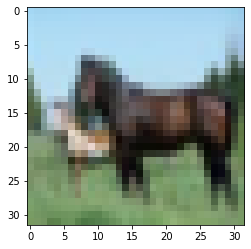

In [3]:
(x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = cifar10.load_data()

print(x_train_cifar.shape)
print(y_train_cifar.shape)

print(x_test_cifar.shape)
print(y_test_cifar.shape)

plt.imshow(x_train_cifar[12,:,:])

### Load Labelled Faces in the Wild dataset

In [4]:
lfw_people = fetch_lfw_people(min_faces_per_person=3, color=True ,resize=0.45)
lfw_people.images.shape

(7606, 56, 42, 3)

### Resize face image dataset

In [5]:
# Resize and convert float to uint8 color
people_image = []
lfw_people_dataset = lfw_people.images[:N_FACE_DATASET]
for img in lfw_people_dataset:
    people_image.append(resize(img, (32,32)))

people_dataset = np.array(people_image).astype(np.uint8)
print(people_dataset.shape)

(7000, 32, 32, 3)


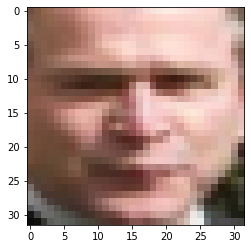

In [6]:
image_a = people_dataset[21]
plt.imshow(image_a)

In [7]:
x_train_people = people_dataset[:N_FACE_TRAIN]
y_train_people = np.full((N_FACE_TRAIN,1), 10)
x_test_people = people_dataset[N_FACE_TRAIN:N_FACE_DATASET]
y_test_people = np.full((N_FACE_TEST,1), 10)

print(x_train_people.shape)
print(y_train_people.shape)

print(x_test_people.shape)
print(y_test_people.shape)

(5000, 32, 32, 3)
(5000, 1)
(2000, 32, 32, 3)
(2000, 1)


### Merge two dataset to CIFARE-11

In [8]:
x_train = np.concatenate((x_train_cifar, x_train_people))
y_train = np.concatenate((y_train_cifar, y_train_people))

x_test = np.concatenate((x_test_cifar, x_test_people))
y_test = np.concatenate((y_test_cifar, y_test_people))

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

print('Total : ', (x_train.shape[0] + x_test.shape[0]))

(55000, 32, 32, 3)
(55000, 1)
(12000, 32, 32, 3)
(12000, 1)
Total :  67000


### Display image

In [9]:
# Helper function to plot some images in the dataset
def plot_dataset(class_name=None):
    mapping = {
        'airplane': 0,
        'automobile': 1,
        'bird': 2,
        'cat': 3,
        'deer': 4,
        'dog': 5,
        'fog': 6,
        'horse': 7,
        'ship': 8,
        'truck': 9,
        'people': 10
    }

    if class_name == None:
        fig, ax = plt.subplots(11, 10, sharey=True, figsize=(11, 10))
        for j in range(11):
            class_index = (y_train == j)[:, 0]
            class_imgs = x_train[class_index, :, :][np.random.choice(5000, 10), :, :]
            for i, img in enumerate(class_imgs):
                ax[j, i].imshow(img)
                ax[j, i].grid('off')
                ax[j, i].set_xticks([])
                ax[j, i].set_yticks([])
                if i == 0:
                    ax[j, i].set_ylabel(list(mapping.keys())[j])
    else:
        class_index = (y_train == mapping[class_name])[:, 0]
        class_imgs = x_train[class_index, :, :][np.random.choice(5000, 10), :, :]
        fig, ax = plt.subplots(1, 10, sharey=True, figsize=(22, 2))
        for i, img in enumerate(class_imgs):
            ax[i].imshow(img)
            ax[i].grid('off')
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            if i == 0:
                ax[i].set_ylabel(class_name)

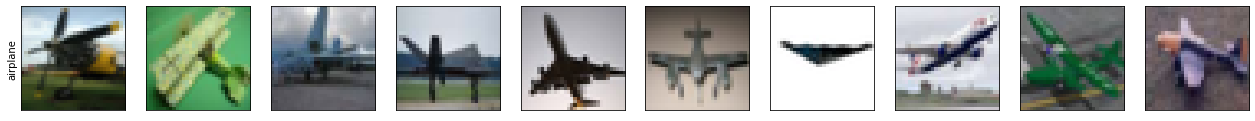

In [10]:
plot_dataset('airplane')

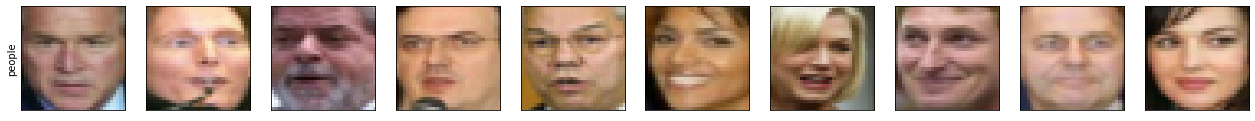

In [11]:
plot_dataset('people')

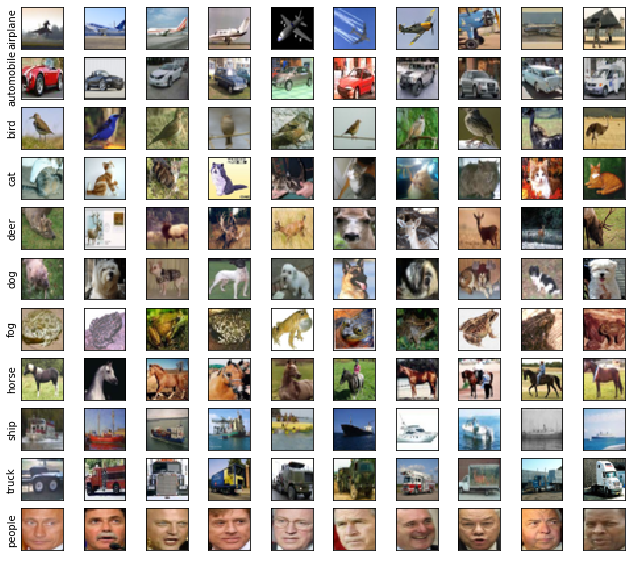

In [12]:
plot_dataset()

### Preprocessing data 

In [13]:
# Normalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Mean subtraction
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

# Convert labels to categorical one-hot encoding
train_labels = keras.utils.to_categorical(y_train, num_classes=11)
test_labels = keras.utils.to_categorical(y_test, num_classes=11)

# Reshape the train and test data into 1D vector
train_data = np.reshape(x_train, [x_train.shape[0], 32*32*3])
test_data = np.reshape(x_test, [x_test.shape[0], 32*32*3])

### Create Model

In [22]:
# 2-layers NN
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_dim=32 * 32 * 3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(11, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               393344    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 11)                1419      
Total params: 411,275
Trainable params: 411,275
Non-trainable params: 0
_________________________________________________________________


In [28]:
# CNN Simple Model
# cnn_model = models.Sequential()
# cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
# cnn_model.add(layers.MaxPooling2D((2, 2)))
# cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# cnn_model.add(layers.MaxPooling2D((2, 2)))
# cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# cnn_model.add(layers.Flatten())
# cnn_model.add(layers.Dense(64, activation='relu'))
# cnn_model.add(layers.Dense(10, activation='softmax'))

cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
cnn_model.add(Activation('relu'))
cnn_model.add(Conv2D(32, (3, 3)))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, (3, 3), padding='same'))
cnn_model.add(Activation('relu'))
cnn_model.add(Conv2D(64, (3, 3)))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())
cnn_model.add(Dense(512))
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(11))
cnn_model.add(Activation('softmax'))
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

### Config optimizer and Backprogation

In [29]:
# Configure the optimizer
# adam = Adam(lr=0.001)
optim = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)
# model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# history = model.fit(train_data, train_labels, validation_data=(test_data, test_labels),
#           epochs=20, batch_size=512)

history = cnn_model.fit(x_train, train_labels, validation_data=(x_test, test_labels),
          epochs=20, batch_size=512)

Train on 55000 samples, validate on 12000 samples
Epoch 1/20
10240/55000 [====>.........................] - ETA: 30:13 - loss: 2.3334 - acc: 0.1776

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

history_dict.keys()

epochs = range(1, 21)
len(history_dict['loss'])

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

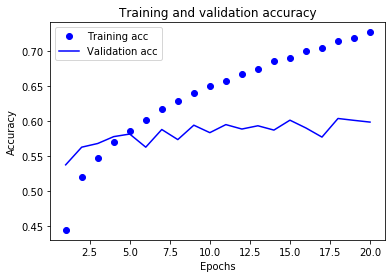

In [27]:
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [18]:
x = image.img_to_array(image_a)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict_classes(images, batch_size=10)
print(classes)

classes = model.predict_classes(image_a, batch_size=10)
print(classes)

NameError: name 'image' is not defined